### Apply AB-Testing Pipeline flows

#### import labrary

In [1]:
import pandas as pd
import seaborn as sns
import os, sys
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
#model library
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
#import script
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
sys.path.insert(0, path_parent+'/scripts')

In [3]:
#read AB Smart testing data
df = pd.read_csv('data/ABtwoCampaignEngView.csv')

EDA Pipeline

In [4]:
# check if there is a null entry
df.isnull().sum()

Unnamed: 0     0
auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [5]:
#numerical description of data
df.describe()

,Unnamed: 0,hour,platform_os,browser,yes,no
count,9.127120e+05,912712.000000,912712.000000,912712.000000,912712.000000,912712.000000
mean,1.196268e+06,10.648142,127.813321,8.211051,0.101645,0.019499
std,6.900511e+05,7.372631,32.217674,3.536780,0.302182,0.138271
min,1.000000e+00,0.000000,101.000000,1.000000,0.000000,0.000000
25%,5.989198e+05,4.000000,101.000000,6.000000,0.000000,0.000000
50%,1.196384e+06,10.000000,101.000000,7.000000,0.000000,0.000000
75%,1.793652e+06,17.000000,162.000000,7.000000,0.000000,0.000000
max,2.391777e+06,23.000000,181.000000,15.000000,1.000000,1.000000


In [6]:
# unique values in each features
df.nunique()

Unnamed: 0     912712
auction_id     892951
experiment          2
date           912712
hour               24
device_make       255
platform_os        68
browser             9
yes                 2
no                  2
dtype: int64

In [7]:
# size of the dataset and also checks if there is a duplicated auction id
df.shape

(912712, 10)

In [8]:
df.dtypes

Unnamed: 0       int64
auction_id      object
experiment      object
date            object
hour             int64
device_make     object
platform_os      int64
browser          int64
yes            float64
no             float64
dtype: object

In [9]:
#drop index column
df=df.drop('Unnamed: 0', axis=1)

In [10]:
df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,8ec30aff-2332-4a1f-9330-b93abb32bc94,control,<built-in method date of Timestamp object at 0...,15,LG,156,6,0.0,0.0
1,4e1bcb56-357c-4186-9d39-3be82e3519f1,control,<built-in method date of Timestamp object at 0...,7,Samsung,162,6,0.0,0.0
2,dd6ec327-fcfd-4a80-89c0-dccd3dd80f09,control,<built-in method date of Timestamp object at 0...,14,Apple,178,15,0.0,0.0
3,b5222d0f-39e3-4c02-a12f-1ef09d4f861f,control,<built-in method date of Timestamp object at 0...,22,Apple,167,15,0.0,0.0
4,9428377d-1504-4407-87c2-ce518f67eb87,control,<built-in method date of Timestamp object at 0...,21,Samsung,155,15,0.0,0.0
5,f1e7473c-b4cd-40cf-80e5-6379af073571,control,<built-in method date of Timestamp object at 0...,20,Apple,101,6,0.0,0.0
6,8ebcbf69-2d51-48c6-80e3-950dee7fd88c,control,<built-in method date of Timestamp object at 0...,21,Apple,178,7,0.0,0.0
7,0f97a578-ea25-4b40-b3b6-2849519301b1,control,<built-in method date of Timestamp object at 0...,21,Apple,178,7,0.0,0.0
8,9b7191a7-ed44-43ae-aa54-288527f2ab34,control,<built-in method date of Timestamp object at 0...,20,Apple,101,7,0.0,0.0
9,234792c2-589a-4bc8-97d6-9891b4367eec,control,<built-in method date of Timestamp object at 0...,15,Apple,101,7,0.0,0.0


In [11]:
df.yes.value_counts()

0.0    819939
1.0     92773
Name: yes, dtype: int64

In [12]:
df.experiment.value_counts()

control    456356
exposed    456356
Name: experiment, dtype: int64

In [13]:
df.no.value_counts()

0.0    894915
1.0     17797
Name: no, dtype: int64

/home/success/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='platform_os', ylabel='Density'>

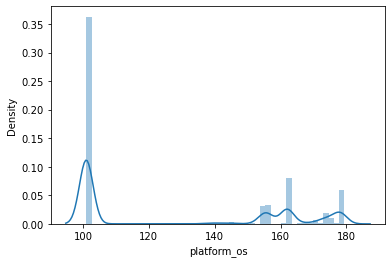

In [14]:
sns.distplot(df['platform_os'])

/home/success/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='browser', ylabel='Density'>

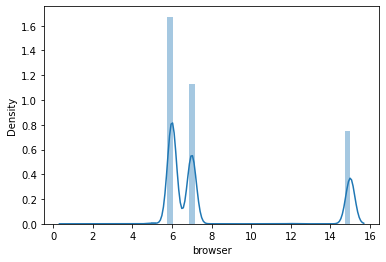

In [15]:
sns.distplot(df['browser'])

Group the target class based on the OS and Platform

In [16]:
#dremove un reponse users
def remove_users(df):
    clean_data = df.query("not (yes == 0 & no == 0)")
    return clean_data
    
clean_data = remove_users(df)

In [17]:
#group the experiment class
clean_data.groupby(['experiment']).count()

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,18899,18899,18899,18899,18899,18899,18899,18899
exposed,91671,91671,91671,91671,91671,91671,91671,91671


Transform the data

In [18]:
#create target group to contine target class
clean_data['target_class'] = clean_data['yes'].map(lambda x: x==1)
clean_df = clean_data.drop(columns = ['yes', 'no'], axis=1)
clean_data.head()

/tmp/ipykernel_98869/493629830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['target_class'] = clean_data['yes'].map(lambda x: x==1)


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,target_class
80,eb941471-f485-4516-b4d3-648e7838d53a,control,<built-in method date of Timestamp object at 0...,15,Apple,101,15,1.0,0.0,True
84,622af8e2-7bcf-4681-a921-442e1f8378f1,control,<built-in method date of Timestamp object at 0...,6,Apple,101,5,1.0,0.0,True
103,56a03982-6278-4083-9554-3a069dbc22c8,control,<built-in method date of Timestamp object at 0...,20,Samsung,162,6,1.0,0.0,True
180,0b4b114a-7be3-435e-beb5-76cbd29ae329,control,<built-in method date of Timestamp object at 0...,8,Apple,101,15,0.0,1.0,False
209,2711e2f3-a624-4243-800e-693a888bc394,control,<built-in method date of Timestamp object at 0...,3,Samsung,162,6,1.0,0.0,True


In [19]:
# Encode aware to 0 and 1
clean_data['target_class']= clean_data['target_class'].astype(int)
clean_data

/tmp/ipykernel_98869/3409392445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['target_class']= clean_data['target_class'].astype(int)


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,target_class
80,eb941471-f485-4516-b4d3-648e7838d53a,control,<built-in method date of Timestamp object at 0...,15,Apple,101,15,1.0,0.0,1
84,622af8e2-7bcf-4681-a921-442e1f8378f1,control,<built-in method date of Timestamp object at 0...,6,Apple,101,5,1.0,0.0,1
103,56a03982-6278-4083-9554-3a069dbc22c8,control,<built-in method date of Timestamp object at 0...,20,Samsung,162,6,1.0,0.0,1
180,0b4b114a-7be3-435e-beb5-76cbd29ae329,control,<built-in method date of Timestamp object at 0...,8,Apple,101,15,0.0,1.0,0
209,2711e2f3-a624-4243-800e-693a888bc394,control,<built-in method date of Timestamp object at 0...,3,Samsung,162,6,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
912689,13225de7-c02c-4b14-ad98-e9edf334054b,exposed,<built-in method date of Timestamp object at 0...,23,Apple,178,7,0.0,1.0,0
912698,9d89a204-2c70-465d-b59c-bc13adc855a5,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,101,6,1.0,0.0,1
912706,46f508f0-4fd5-4cf8-8f80-49ae3d2d27d1,exposed,<built-in method date of Timestamp object at 0...,3,Samsung,101,6,1.0,0.0,1
912707,98c10ba3-932f-4feb-ad01-d1b549dbd905,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,162,15,0.0,1.0,0


# Sklearn Pipeline

In [20]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(df['experiment'])
    df['browser'] = aware_encoder.fit_transform(df['browser'])
    df['target_class'] = aware_encoder.fit_transform(df['target_class'])
    
    return df


def feature_data(df):
    
    feature_data = df[["experiment", "hour", "date", 'device_make', 'platform_os', 'browser', 'target_class']] 
    return feature_data  

In [21]:
clean_data = encode_labels(clean_df)
clean_data = feature_data(clean_df)
clean_data.head()

,experiment,hour,date,device_make,platform_os,browser,target_class
80,0,15,27623,7,101,6,1
84,0,6,27624,7,101,1,1
103,0,20,27622,60,162,2,1
180,0,8,27621,7,101,6,0
209,0,3,27620,60,162,2,1


In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [23]:
Y_col = 'target_class'
X_cols = clean_data.loc[:, clean_data.columns != Y_col].columns

X_train,X_test,y_train,y_test=train_test_split(clean_data[X_cols], clean_data[Y_col],test_size=0.2, random_state=42)

In [24]:
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',LogisticRegression(random_state=0))])
pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('dt_classifier',DecisionTreeClassifier())])
pipeline_randomforest=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier())])
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest]

#hyperparameter tuning

In [25]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [26]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Test Accuracy: 0.8384733652889572
Decision Tree Test Accuracy: 0.7829881523017094
RandomForest Test Accuracy: 0.8186669078411866


In [27]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:Logistic Regression


Hyperparameter Tuning Using Grid SearchCV

In [ ]:
# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])
# Create dictionary with candidate learning algorithms and hyperparameters
grid_param = [
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(0, 4, 10)
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2'],
                 "classifier__C": np.logspace(0, 4, 10),
                 "classifier__solver":['newton-cg','saga','sag','liblinear'] 
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 50, 50],
                 "classifier__max_depth":[5,8,15,25,30,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, 
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)

### MakePipelines In SKLearn

In [ ]:
# Create a pipeline
pipe = make_pipeline((RandomForestClassifier()))
# Create hyperparameters using random forest
grid_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [10, 100, 1000],
                 "randomforestclassifier__max_depth":[5,8,15,25,30,None],
                 "randomforestclassifier__min_samples_leaf":[1,2,5,10,15,100],
                 "randomforestclassifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)

In [ ]:
best_model.score(X_test,y_test)

## Training the models

* Random Forest (It's my favorite)
* Desicion Tree
* Logistic Regression Classifier
* Bernouilli Naive Bias
* Gaussian Naive Bias
* KNN (K-Nearest Neighbors)
* XGBoost (It's new and have acurate predictions)

### Random Forest

In [29]:
# Define Random Forest Model
rf = RandomForestClassifier(n_estimators=100)

# We fit our model with our train data
rf.fit(X_train, y_train)

# Then predict results from X_test data
pred_rf = rf.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_rf[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 1 1 1 0 1 1 1 1]
Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


## Desicion Tree

In [30]:
# Define Decision Tree Model
dt = DecisionTreeClassifier()
# We fit our model with our train data
dt.fit(X_train, y_train)
# Then predict results from X_test data
pred_dt = dt.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_dt[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 1 1 1 0 1 1 1 1]
Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


### Logistic Regression

In [31]:
# Define Logistic Regression Model
log = LogisticRegression()
# We fit our model with our train data
log.fit(X_train, y_train)
# Then predict results from X_test data
pred_log = log.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_log[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 1 1 1 1 1 1 1 1]
Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


## Bernouilli Naive Bias

In [33]:
from sklearn.naive_bayes import BernoulliNB
# Define Bernouilli Naive Bias Model
bnb = BernoulliNB()
# We fit our model with our train data
bnb.fit(X_train, y_train)
# Then predict results from X_test data
pred_bnb = bnb.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_bnb[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 1 1 1 1 1 1 1 1]
Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


## Gaussian Naive Bias

In [34]:
from sklearn.naive_bayes import GaussianNB
# Define Gaussian Naive Bias Model
gnb = GaussianNB()
# We fit our model with our train data
gnb.fit(X_train, y_train)
# Then predict results from X_test data
pred_gnb = gnb.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_gnb[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 1 1 1 1 1 1 1 1]
Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


## KNN - K-Nearest Neighbours

In [35]:
from sklearn.neighbors import KNeighborsClassifier
# Define KNN Model
knn = KNeighborsClassifier(n_neighbors=3, metric="minkowski")
# We fit our model with our train data
knn.fit(X_train, y_train)
# Then predict results from X_test data
pred_knn = knn.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_knn[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 1 1 1 1 1 1 1 1]
Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


## XGBoost

In [38]:
from xgboost import XGBClassifier
# Define XGBoost Model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# We fit our model with our train data
xgb.fit(
    X_train, y_train,
    # That means if model don't improve it self in 5 rounds, it will stop learning
    # So you can save your time and don't overtrain your model.
    early_stopping_rounds=5,
    # We provide Test data's to evaluate model performance
    eval_set=[(X_test, y_test)],
    verbose=False
 )
# Then predict results from X_test data
pred_xgb = xgb.predict(X_test)

# See First 10 Predictions and They Actual Values
# print("Predicted:", pred_xgb[0:10])
print("Actual:", y_test[0:10])

/home/success/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Actual: 607152    1
297429    0
832315    1
664875    1
791170    1
614363    1
515326    1
694272    1
259692    1
509084    1
Name: target_class, dtype: int64


# Compare the models performances

## Confusion Matrices

In [39]:
# Confusion Matrixes
# First parameter is actual value
# second parameter is value that we prediceted
from sklearn.metrics import accuracy_score, confusion_matrix
# Random Forest 
cm_rf = confusion_matrix(y_test, pred_rf)
# Desicion Tree
cm_dt = confusion_matrix(y_test, pred_dt)
# Logistic Regression
cm_log = confusion_matrix(y_test, pred_log)
# Bernouilli Naive Bias
cm_bnb = confusion_matrix(y_test, pred_bnb)
# Gaussian Naive Bias
cm_gnb = confusion_matrix(y_test, pred_gnb)
# KNN (K-Nearest Neighbors)
cm_knn = confusion_matrix(y_test, pred_knn)
# XGBoost 
cm_xgb = confusion_matrix(y_test, pred_xgb)

print("***********************")
print("Confusion Matrixes")
print("***********************")
print("Random Forest:\n", cm_rf)
print("Desicion Tree:\n", cm_dt)
print("Logistic Regression:\n", cm_log)
print("Bernouilli Naive Bias:\n", cm_bnb)
print("Gaussian Naive Bias:\n", cm_gnb)
print("KNN (K-Nearest Neighbors):\n", cm_knn)
print("XGBoost:\n", cm_xgb)

***********************
Confusion Matrixes
***********************
Random Forest:
 [[ 1208  2463]
 [ 1910 16533]]
Desicion Tree:
 [[ 1285  2386]
 [ 2255 16188]]
Logistic Regression:
 [[   99  3572]
 [   96 18347]]
Bernouilli Naive Bias:
 [[    0  3671]
 [    3 18440]]
Gaussian Naive Bias:
 [[ 1297  2374]
 [ 1380 17063]]
KNN (K-Nearest Neighbors):
 [[  970  2701]
 [ 1268 17175]]
XGBoost:
 [[  941  2730]
 [  611 17832]]


## Accuracy scores

In [40]:
# Accuracy Scores
# First parameter is actual value
# second parameter is value that we prediceted

# Random Forest 
acc_rf = accuracy_score(y_test, pred_rf)
# Desicion Tree
acc_dt = accuracy_score(y_test, pred_dt)
# Logistic Regression
acc_log = accuracy_score(y_test, pred_log)
# Bernouilli Naive Bias
acc_bnb = accuracy_score(y_test, pred_bnb)
# Gaussian Naive Bias
acc_gnb = accuracy_score(y_test, pred_gnb)
# KNN (K-Nearest Neighbors)
acc_knn = accuracy_score(y_test, pred_knn)
# XGBoost 
acc_xgb = accuracy_score(y_test, pred_xgb)

print("***********************")
print("Accuracy Scores")
print("***********************")
print("Random Forest:", acc_rf)
print("Desicion Tree:", acc_dt)
print("Logistic Regression:", acc_log)
print("Bernouilli Naive Bias:", acc_bnb)
print("Gaussian Naive Bias:", acc_gnb)
print("KNN (K-Nearest Neighbors):", acc_knn)
print("XGBoost:", acc_xgb)

***********************
Accuracy Scores
***********************
Random Forest: 0.802251967079678
Desicion Tree: 0.7901329474541015
Logistic Regression: 0.8341322239305418
Bernouilli Naive Bias: 0.8338609025956407
Gaussian Naive Bias: 0.8302432847969612
KNN (K-Nearest Neighbors): 0.8205209369630099
XGBoost: 0.8489192366826445


As you see XGBoost, Logistic Regression and Bernouilli Naive Bias: give us best results